## Detection with Augmentation
In this notebook, we re going to use data augmentation in our dataset to improve generalization in classification model

In [2]:
!pip install git+https://github.com/obsessor-ak1/Skin_Cancer_Detection_HAM10000.git --no-deps

  Cloning https://github.com/obsessor-ak1/Skin_Cancer_Detection_HAM10000.git to /tmp/pip-req-build-yllk5bbw
  Running command git clone --filter=blob:none --quiet https://github.com/obsessor-ak1/Skin_Cancer_Detection_HAM10000.git /tmp/pip-req-build-yllk5bbw
  Resolved https://github.com/obsessor-ak1/Skin_Cancer_Detection_HAM10000.git to commit 4e756206a6132bfa6823dd0ec67a58c865eb166f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for skin_cancer_detection: filename=skin_cancer_detection-0.1.0-py3-none-any.whl size=6586 sha256=1a401464d83b58daf3274e9f6566b4478cc36389c389b63a0d89eab26fe40996
  Stored in directory: /tmp/pip-ephem-wheel-cache-8ue8yuj3/wheels/1c/73/8d/15507a4fb68edbf3c8bf56d26a749022d0075ab6b50ec069ff
Successfully built skin_cancer_detection


In [3]:
import kagglehub
from sklearn.metrics import accuracy_score, precision_score, recall_score
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision.models import alexnet
from torchvision.transforms import v2 as tfs

from exp_tools.basic_utils import init_module, plot_history
from exp_tools.data_utils import HAM10000Dataset, Explorer
from exp_tools.trainer import Trainer

### Loading the Dataset
First we will load the dataset but this time with augmentation
#### Augmentation Pipeline
Following is the augmentation pipeline for training and test data

In [4]:
image_size = (224, 224)
train_transform = tfs.Compose([
    tfs.ToImage(),
    tfs.RandomHorizontalFlip(0.5),
    tfs.ColorJitter(brightness=(0.5, 1.5), contrast=0.2),
    tfs.Resize(image_size),
    tfs.ToDtype(torch.float32, scale=True)
])
test_transform = tfs.Compose([
    tfs.ToImage(),
    tfs.Resize(image_size),
    tfs.ToDtype(torch.float32, scale=True)
])

In [5]:
local_path = "../data/HMNIST"
kaggle_path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

train_set = HAM10000Dataset(
    dataset_dir=kaggle_path,
    transform=train_transform,
    target_transform=torch.tensor,
    split="train"
)
test_set = HAM10000Dataset(
    dataset_dir=kaggle_path,
    transform=test_transform,
    target_transform=torch.tensor,
    split="test"
)
print(f"Train samples: {len(train_set)}")
print(f"Test samples: {len(test_set)}")

Train samples: 8012
Test samples: 2003


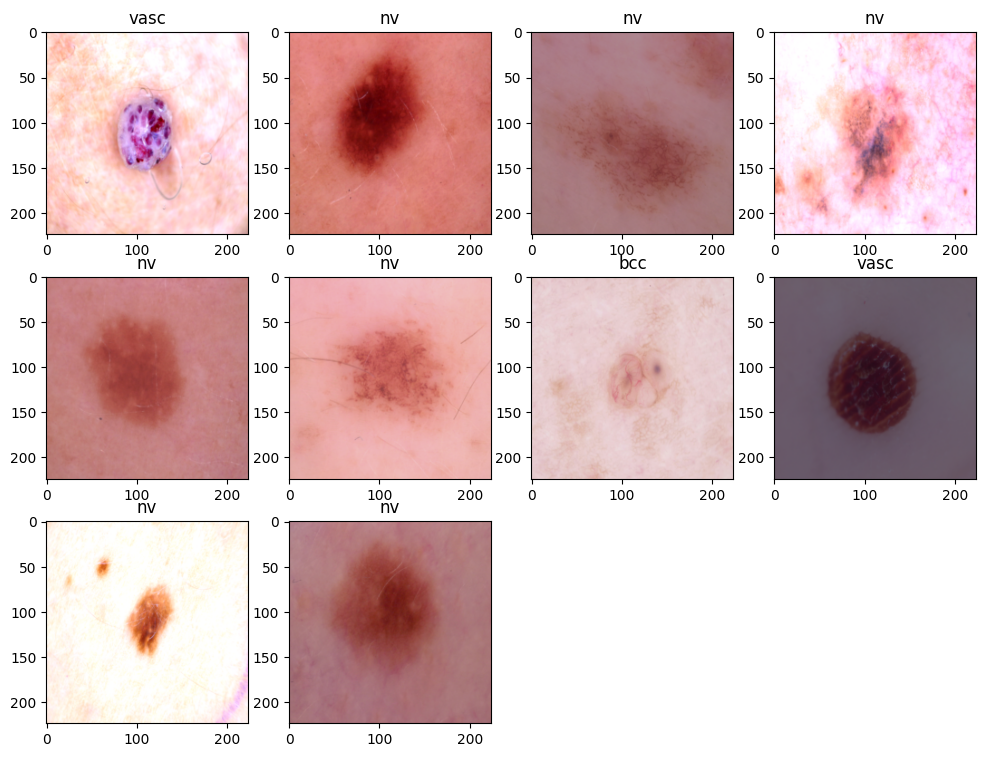

In [6]:
explorer = Explorer(train_set)
explorer.show_images()

#### Preparing the Sampler
Here also, we will use weighted random sampler as there is a huge class imbalance in the dataset.

In [7]:
label_weights = 1 / train_set.sample_dist
sample_weights = [
    label_weights[train_set.label_map[label_str]].item()
    for label_str in train_set.metadata.dx
]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_set), replacement=True)

In [8]:
batch_size = 64
num_workers = 4
train_dl = DataLoader(train_set, batch_size=batch_size, sampler=sampler, num_workers=num_workers)
test_dl = DataLoader(test_set, batch_size=batch_size, num_workers=num_workers)

### The Model
Now, we are going to train our model. For this again, we will be using AlexNet

In [9]:
model = alexnet(num_classes=len(train_set.label_map))
model.apply(init_module)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [18]:
def class_wise_precision(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average=None, zero_division=0.0)
    return {
        label_str: precision[label_id] for label_str, label_id in train_set.label_map.items()
    }

In [19]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
metrics = {
    "accuracy": accuracy_score,
    "average_precision": lambda y_true, y_pred: precision_score(y_true, y_pred, average="macro", zero_division=0.0),
    "average_recall": lambda y_true, y_pred: recall_score(y_true, y_pred, average="macro", zero_division=0.0),
    "precision": class_wise_precision
}
trainer = Trainer(
    max_epochs=15, device="cuda", clip_grad=True, clip_val=2.0, metrics=metrics
)

In [20]:
trainer.fit(model, criterion, optimizer, train_dl, test_dl)

Epoch 1/15
[--------------------------------------------------] - batch: 126/126 - 100.00 complete
Train loss: 1.579652896893959
Val loss: 1.4068297540552308
Epoch 2/15
[--------------------------------------------------] - batch: 126/126 - 100.00 complete
Train loss: 1.4874755632740464
Val loss: 1.500191094276611
Epoch 3/15
[--------------------------------------------------] - batch: 126/126 - 100.00 complete
Train loss: 1.4185586483313093
Val loss: 1.109822667365186
Epoch 4/15
[--------------------------------------------------] - batch: 126/126 - 100.00 complete
Train loss: 1.379037381349298
Val loss: 1.2477423179405545
Epoch 5/15
[--------------------------------------------------] - batch: 126/126 - 100.00 complete
Train loss: 1.3480739885726334
Val loss: 1.0994815435400023
Epoch 6/15
[--------------------------------------------------] - batch: 126/126 - 100.00 complete
Train loss: 1.3283767135989588
Val loss: 1.1897787899597252
Epoch 7/15
[--------------------------------------

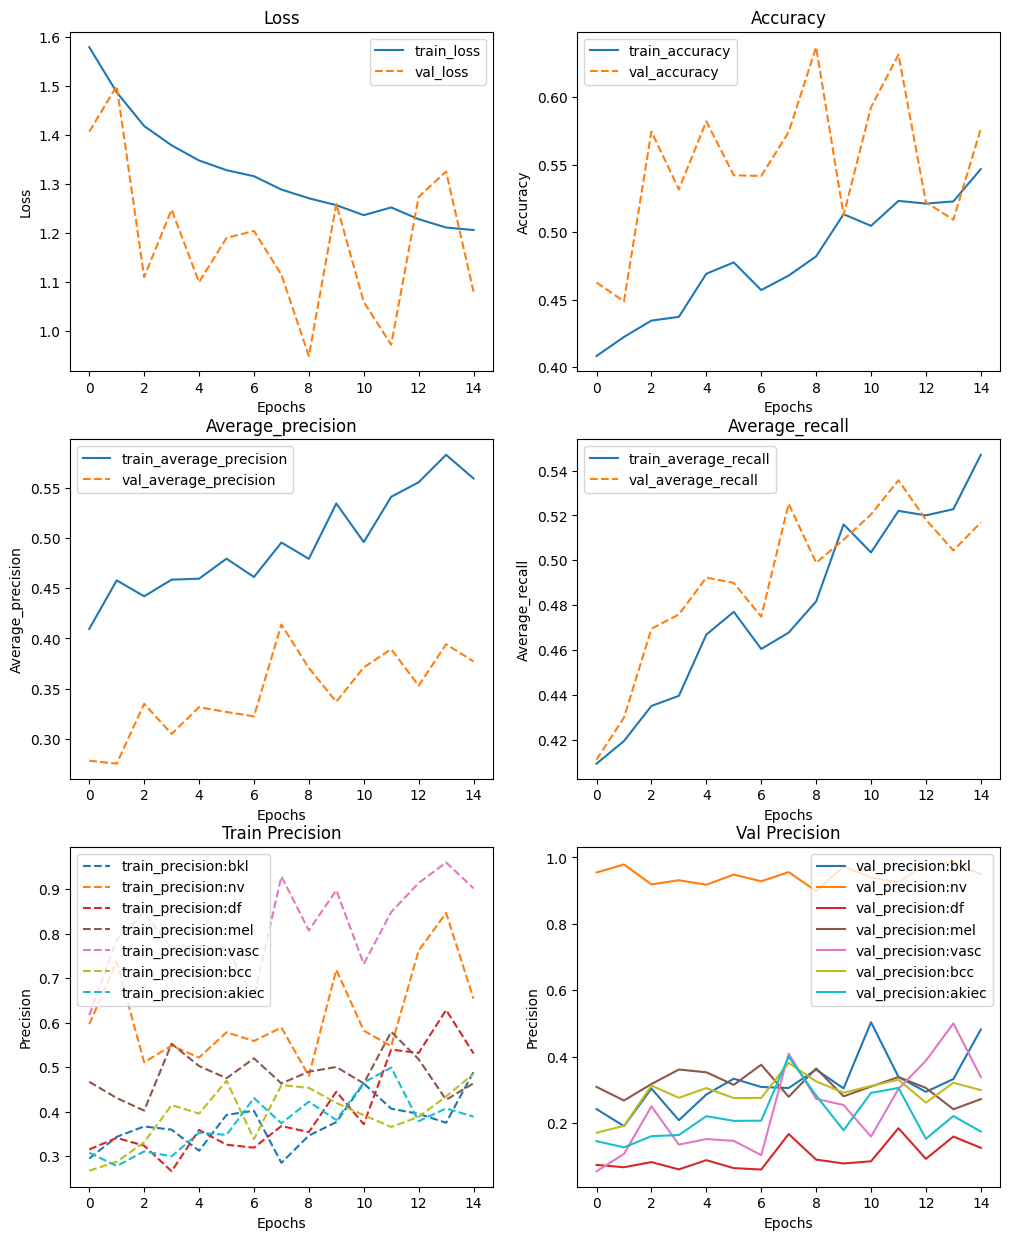

In [21]:
trainer.current_history.plot_history()

So, all tools are working fine. Just the linestyle for the plots in multiplots is different which will be a minor fix.